In [1]:
import torch
import torch.nn as nn
import torch_geometric.nn as tgnn
from typing import Tuple
from datasets import Dataset

from tqdm import trange
from collections import Counter
import pandas as pd
import networkx as nx
from cdlib import algorithms
import matplotlib.pyplot as plt

Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'leidenalg', 'graph_tool', 'wurlitzer', 'bayanpy'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'ASLPAw', 'pyclustering'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'leidenalg', 'wurlitzer'}


## 0. preparatory
### 0.1 data

In [2]:
cpc_id = Dataset.load_from_disk('/Users/xiaoen/Documents/科研/论文/链接预测/TOD-Code/data/CPC2ID')
cpc_id = cpc_id.to_list()
cpc_id = {c['CPC']:c['id'] for c in cpc_id}
id_cpc = {c[1]:c[0] for c in cpc_id.items()}
cpc_set = set(list(cpc_id.keys()))

In [3]:
dataset = Dataset.load_from_disk('/Users/xiaoen/Documents/科研/论文/链接预测/TOD-Code/data/traindataset')
test_dataset = dataset['data'][1]

In [4]:
dataset = Dataset.load_from_disk('/Users/xiaoen/Documents/科研/论文/链接预测/TOD-Code/case/case_dataset')
case_dataset = dataset['data'][0]

In [5]:
def deal_cpc(cpc_list):
    if pd.isna(cpc_list):
        return []
    else:
        cpc_raw = cpc_list.split(' | ')
        cpcs = []
        for cpc in cpc_raw:
            a = cpc[:4]
            b = cpc[4:8].lstrip('0')
            c = cpc[8:]
            cpcs.append(a + b + '/' + c)
        return cpcs

In [6]:
def make_dataset(file_name):
    patents = []
    data_frame = pd.read_excel(file_name, header=1)
    for n in trange(len(data_frame)):
        p = {
            'PN': data_frame.iloc[n][4] if not pd.isna(data_frame.iloc[n][4]) else 'NaN',  # Publication_Number
            'TI': data_frame.iloc[n][0] if not pd.isna(data_frame.iloc[n][0]) else 'NaN',  # Title
            'AB': data_frame.iloc[n][5] if not pd.isna(data_frame.iloc[n][5]) else 'NaN',  # Abstract
            'CPC': deal_cpc(data_frame.iloc[n][6]),  # CPC
            'PCN': int(data_frame.iloc[n][1]) if not pd.isna(data_frame.iloc[n][1]) else 0,  # Patent Claims Number
            'PA': data_frame.iloc[n][7].split(' | ') if not pd.isna(data_frame.iloc[n][7]) else [],  # Patent Assignee
            'PI': data_frame.iloc[n][8].split(' | ') if not pd.isna(data_frame.iloc[n][8]) else [],  # Patent Inventor
            'UPC': data_frame.iloc[n][2].split(' | ') if not pd.isna(data_frame.iloc[n][2]) else [],
            # Ultimate Parent Company
            'PAT': data_frame.iloc[n][11] if not pd.isna(data_frame.iloc[n][11]) else 'NaN',  # Patent Application Time
            'PPT': data_frame.iloc[n][3] if not pd.isna(data_frame.iloc[n][3]) else 'NaN',  # Patent Publication Time
            'PCing': data_frame.iloc[n][9].split(' | ') if not pd.isna(data_frame.iloc[n][9]) else [],  # Patent Citing
            'PCed': data_frame.iloc[n][10].split(' | ') if not pd.isna(data_frame.iloc[n][10]) else [],  # Patent Cited
        }
        if len(p['CPC']) > 1:
            patents.append(p)
    return Dataset.from_list(patents)

In [7]:
case_data = make_dataset('/Users/xiaoen/Documents/科研/论文/链接预测/TOD-Code/case/ZD_23.xlsx')

100%|██████████| 7395/7395 [00:01<00:00, 3811.85it/s]


### 0.2 model

In [8]:
class GAT(nn.Module):
    def __init__(
            self,
            dim_in: int,
            hidden_size: int,
            output_size: int,
            dropout: float = 0.1
    ):
        super().__init__()
        self.dim_in = dim_in
        self.dropout = dropout

        self.conv1 = tgnn.GATv2Conv(
            in_channels=dim_in,
            out_channels=hidden_size,
            heads=2,
            dropout=self.dropout,
            residual=True
        )

        self.conv2 = tgnn.GATv2Conv(
            in_channels=hidden_size * 2,
            out_channels=output_size,
            heads=1,
            dropout=self.dropout,
            residual=True
        )

        self.dim_out = output_size

    def forward(self, x: torch.Tensor, edge_index: torch.Tensor) -> torch.Tensor:
        h = self.conv1(x, edge_index)
        h = nn.functional.dropout(h, p=self.dropout, training=self.training)

        h = self.conv2(h, edge_index)
        h = nn.functional.dropout(h, p=self.dropout, training=self.training)

        return h

In [9]:
class LinkPredModel(nn.Module):
    def __init__(
            self,
            dim_in: int,
            gnn_hidden_size: int,
            gnn_output_size: int,
            hidden_dims: Tuple[int, ...] = (16, 4),
            dropout: float = 0.1,
    ):
        super().__init__()

        self.gnn = GAT(
            dim_in=dim_in,
            hidden_size=gnn_hidden_size,
            output_size=gnn_output_size,
            dropout=dropout
        )

        self.input_dim = self.gnn.dim_out + 16
        self.dropout = dropout

        self.in_layer = nn.Linear(self.input_dim, hidden_dims[0])
        self.hidden_layer = nn.Linear(hidden_dims[0], hidden_dims[1])
        self.out_layer = nn.Linear(hidden_dims[1], 1)

        self.lrelu = nn.LeakyReLU(0.01)
        self.bn0 = nn.BatchNorm1d(self.input_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dims[0])
        self.bn2 = nn.BatchNorm1d(hidden_dims[1])

    def forward(self, x: torch.Tensor, edge_index: torch.Tensor, label_edge_index: torch.Tensor, label_edge_feature: torch.Tensor) -> torch.Tensor:
        h = self.gnn(x, edge_index)

        h_src = h[label_edge_index[0, :]]
        h_dst = h[label_edge_index[1, :]]

        src_dst_mult = h_src * h_dst

        all_features = torch.cat([src_dst_mult, label_edge_feature], dim=1)

        _out = self.bn0(all_features)

        _out = self.in_layer(_out)
        _out = self.bn1(_out)
        _out = self.lrelu(_out)
        _out = nn.functional.dropout(_out, p=self.dropout, training=self.training)  # 添加 Dropout


        _out = self.hidden_layer(_out)
        _out = self.bn2(_out)
        _out = self.lrelu(_out)
        _out = nn.functional.dropout(_out, p=self.dropout, training=self.training)  # 添加 Dropout

        _out = self.out_layer(_out)

        return _out

In [10]:
model = torch.load("/Users/xiaoen/Documents/科研/论文/链接预测/TOD-Code/all_method/statistically_significant/GAT-models/GAT_Model_15.pth", map_location='mps',weights_only=False)
model.eval()

LinkPredModel(
  (gnn): GAT(
    (conv1): GATv2Conv(100, 16, heads=2)
    (conv2): GATv2Conv(32, 10, heads=1)
  )
  (in_layer): Linear(in_features=26, out_features=16, bias=True)
  (hidden_layer): Linear(in_features=16, out_features=4, bias=True)
  (out_layer): Linear(in_features=4, out_features=1, bias=True)
  (lrelu): LeakyReLU(negative_slope=0.01)
  (bn0): BatchNorm1d(26, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

## 1. prediction

In [11]:
case_dataset.keys()

dict_keys(['edge_index', 'label', 'label_edge_feature', 'label_edge_index', 'x', 'x_feature'])

In [12]:
case_x = torch.tensor(case_dataset['x'])
case_edge_index = torch.tensor(case_dataset['edge_index']).T
case_label_edge_index = torch.tensor(case_dataset['label_edge_index']).T
case_label_edge_feature = torch.tensor(case_dataset['label_edge_feature'])
case_label = torch.tensor(case_dataset['label'])

In [13]:
device = torch.device('mps')

In [14]:
k_ratio = [0.2, 0.5, 1, 2, 5, 10]

In [15]:
def recommend_k(out_score, k_top):
    index = sorted(range(len(out_score)), key=lambda i: out_score[i], reverse=True)[:k_top]
    return set(index)

In [16]:
model.eval()
model.to(device)
with torch.no_grad():
    out = model.forward(
        case_x.to(device),
        case_edge_index.to(device),
        case_label_edge_index.to(device),
        case_label_edge_feature.to(device)
    )
    out = out.cpu().squeeze()

In [17]:
label_index = []
for i in range(len(case_label)):
    if case_label[i] == 1:
        label_index.append(i)
label_index = set(label_index)

In [18]:
prise = []
recall = []
cor = []
number = []

for k in k_ratio:
    num = int(round(len(case_label)*k/100,0)) if int(round(len(case_label)*k/100,0))>0 else 1
    index = recommend_k(out, num)
    correct = len(index.intersection(label_index))
    p = round(correct/num,4)
    r = round(correct/len(label_index),4) if len(label_index)>0 else 0

    number.append(num)
    cor.append(correct)
    prise.append(p)
    recall.append(r)

In [19]:
number, cor, prise, recall

([41, 102, 203, 406, 1015, 2030],
 [41, 99, 191, 358, 758, 1137],
 [1.0, 0.9706, 0.9409, 0.8818, 0.7468, 0.5601],
 [0.0233, 0.0563, 0.1086, 0.2036, 0.4312, 0.6468])

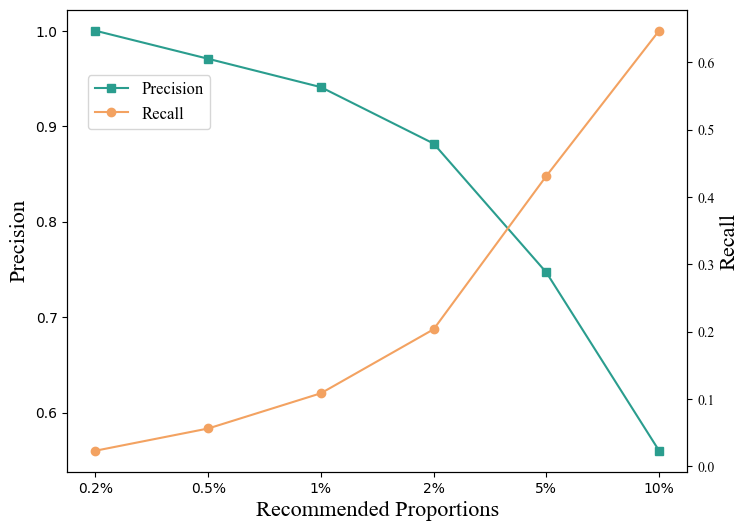

In [20]:
TopK = [0.2, 0.5, 1, 2, 5, 10]
TopK = [f"{str(i)}%" for i in TopK]
fig, ax1 = plt.subplots(figsize=(8, 6))
plt.rcdefaults()
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.serif'] = ['Times New Roman']


line1, = ax1.plot(range(len(TopK)), prise, marker='s', color='#2A9D8E', label='Precision')
ax1.set_ylabel('Precision', fontsize=16, fontfamily='Times New Roman')
ax1.set_xticks(range(len(TopK)))
ax1.set_xticklabels(TopK)
ax1.set_xlabel("Recommended Proportions", fontsize=16, fontfamily='Times New Roman')

ax2 = ax1.twinx()
line2, = ax2.plot(range(len(TopK)), recall, marker='o', color='#F3A261', label='Recall')
ax2.set_ylabel('Recall', fontsize=16, fontfamily='Times New Roman')

lines = [line1, line2]
labels = [line.get_label() for line in lines]
plt.legend(lines, labels, loc='center left', bbox_to_anchor=(0.02, 0.8), fontsize=12)

plt.savefig('/Users/xiaoen/Documents/科研/论文/链接预测/TOD-Code/case/precision_recall.png', dpi=300, bbox_inches='tight')

## 2. max-Cliques

In [21]:
pred_100_index = list(recommend_k(out, 100))
len(pred_100_index), len(set(pred_100_index).intersection(label_index))

(100, 97)

In [22]:
pred_100_edges = []
for i in list(pred_100_index):
    pred_100_edges.append((id_cpc[case_label_edge_index[0][i].item()], id_cpc[case_label_edge_index[1][i].item()]))

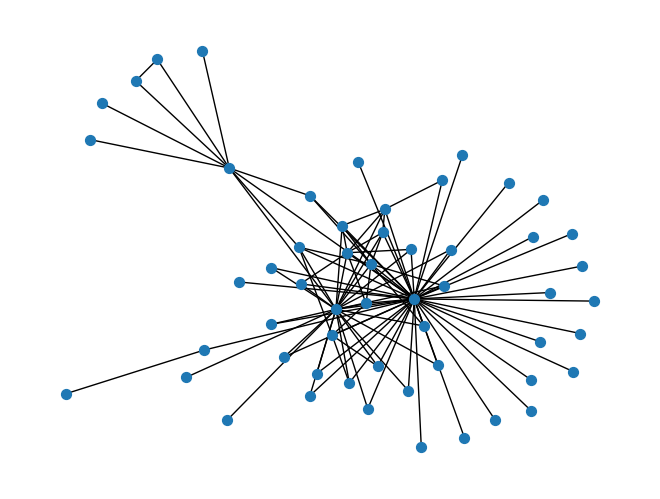

In [23]:
G = nx.Graph()
G.add_edges_from(pred_100_edges)
nx.draw(G, node_size=50)

In [24]:
cliques = list(nx.find_cliques(G))
cliques = [c for c in cliques if len(c) > 2]
len(cliques), len(G.nodes())

(31, 55)

In [25]:
cliques_length = [len(c) for c in cliques]
cliques_length = Counter(cliques_length)
cliques_length

Counter({3: 19, 4: 10, 5: 2})

In [26]:
cliques_length_dic = {}
for k in cliques_length.keys():
    cliques_length_dic[k] = []
for c in cliques:
    cliques_length_dic[len(c)].append(set(c))

In [27]:
for k in range(3,6):
    mark = 0
    for c in cliques_length_dic[k]:
        for case in case_data:
            cpc = set(case['CPC']) - (set(case['CPC']) - cpc_set)
            prise = len(cpc.intersection(c))/len(c) if len(c) else 0
            if prise >=1 and len(cpc)>2:
                mark += 1
                print(c, case['PN'])
                break
    print(k, mark)

{'B60W60/0051', 'B60W50/082', 'B60W60/0053'} US20230303125A1
{'B60W60/0015', 'B60W50/0205', 'B60W60/001'} CN116811878A
{'B60W60/0015', 'B60W50/0098', 'B60W60/001'} CN116513246A
{'B60W60/0015', 'B60W2554/802', 'B60W60/001'} CN116749960A
{'B60W60/0015', 'B60W50/00', 'B60W60/001'} WO2023245217A1
{'B60W60/0015', 'B60W40/06', 'B60W60/001'} CN116853289A
{'B60W60/0015', 'B60W50/0097', 'B60W60/001'} CN116872962A
{'B60W60/0027', 'B60W2554/4029', 'B60W60/001'} US20240085917A1
{'B60W60/0016', 'B60W2050/146', 'B60W60/001'} WO2023158126A1
{'B60W50/0098', 'B60W60/00', 'B60W60/001'} US20230278580A1
{'B60W50/14', 'B60W60/00', 'B60W60/001'} CN116872923A
{'B60W50/00', 'B60W60/00', 'B60W60/001'} US20230271631A1
{'B60W40/02', 'B60W60/00', 'B60W60/001'} WO2023158126A1
3 13
4 0
5 0


In [28]:
for k in range(3,6):
    print(k)
    for c in cliques_length_dic[k]:
        print(c)

3
{'B60W60/0051', 'B60W50/082', 'B60W60/0053'}
{'B60W60/0015', 'G08G1/166', 'B60W60/001'}
{'B60W60/0015', 'B60W50/0205', 'B60W60/001'}
{'B60W60/0015', 'B60W30/143', 'B60W60/001'}
{'B60W60/0015', 'G05D1/0214', 'B60W60/001'}
{'B60W60/0015', 'B60W50/0098', 'B60W60/001'}
{'B60W60/0015', 'B60W2050/0005', 'B60W60/001'}
{'B60W60/0015', 'B60W2554/802', 'B60W60/001'}
{'B60W60/0015', 'B60W50/00', 'B60W60/001'}
{'B60W60/0015', 'B60W2554/80', 'B60W60/001'}
{'B60W60/0015', 'B60W40/06', 'B60W60/001'}
{'B60W60/0015', 'B60W50/0097', 'B60W60/001'}
{'B60W60/0027', 'B60W2554/4029', 'B60W60/001'}
{'B60W60/0016', 'B60W2050/146', 'B60W60/001'}
{'B60W2050/146', 'B60W60/0053', 'B60W60/001'}
{'B60W50/0098', 'B60W60/00', 'B60W60/001'}
{'B60W50/14', 'B60W60/00', 'B60W60/001'}
{'B60W50/00', 'B60W60/00', 'B60W60/001'}
{'B60W40/02', 'B60W60/00', 'B60W60/001'}
4
{'B60W60/0015', 'B60W40/105', 'B60W60/0016', 'B60W60/001'}
{'B60W60/0015', 'B60W30/08', 'B60W60/0016', 'B60W60/001'}
{'B60W60/0015', 'B60W30/0956', 'B60W60/

In [29]:
high_cliques = {'B60W60/0015', 'B60W60/0027', 'B60W60/001', 'B60W60/0011', 'B60W30/0956'}
for case in case_data:
    cpc = set(case['CPC']) - (set(case['CPC']) - cpc_set)
    prise = len(cpc.intersection(high_cliques))/len(high_cliques) if len(high_cliques) else 0
    if prise >=0.6 and len(cpc)>2:
        print(high_cliques, case['PN'], cpc.intersection(high_cliques), len(cpc.intersection(high_cliques)))

{'B60W30/0956', 'B60W60/0015', 'B60W60/0027', 'B60W60/0011', 'B60W60/001'} US20240067213A1 {'B60W30/0956', 'B60W60/0011', 'B60W60/001'} 3
{'B60W30/0956', 'B60W60/0015', 'B60W60/0027', 'B60W60/0011', 'B60W60/001'} US20240101152A1 {'B60W30/0956', 'B60W60/0011', 'B60W60/0015'} 3
{'B60W30/0956', 'B60W60/0015', 'B60W60/0027', 'B60W60/0011', 'B60W60/001'} US20230382430A1 {'B60W60/0027', 'B60W30/0956', 'B60W60/0011'} 3
{'B60W30/0956', 'B60W60/0015', 'B60W60/0027', 'B60W60/0011', 'B60W60/001'} CN116513246A {'B60W30/0956', 'B60W60/001', 'B60W60/0015'} 3
{'B60W30/0956', 'B60W60/0015', 'B60W60/0027', 'B60W60/0011', 'B60W60/001'} CN116853289A {'B60W30/0956', 'B60W60/001', 'B60W60/0015'} 3
{'B60W30/0956', 'B60W60/0015', 'B60W60/0027', 'B60W60/0011', 'B60W60/001'} US20230399021A1 {'B60W30/0956', 'B60W60/0011', 'B60W60/0015'} 3
{'B60W30/0956', 'B60W60/0015', 'B60W60/0027', 'B60W60/0011', 'B60W60/001'} CN116552516A {'B60W30/0956', 'B60W60/001', 'B60W60/0015'} 3
{'B60W30/0956', 'B60W60/0015', 'B60W60/0

## 3. Overlapping community detection

In [30]:
pred_1000_index = list(recommend_k(out, 1000))
len(pred_1000_index), len(set(pred_1000_index).intersection(label_index))

(1000, 746)

In [31]:
pred_1000_edges = []
for i in list(pred_1000_index):
    pred_1000_edges.append((id_cpc[case_label_edge_index[0][i].item()], id_cpc[case_label_edge_index[1][i].item()]))

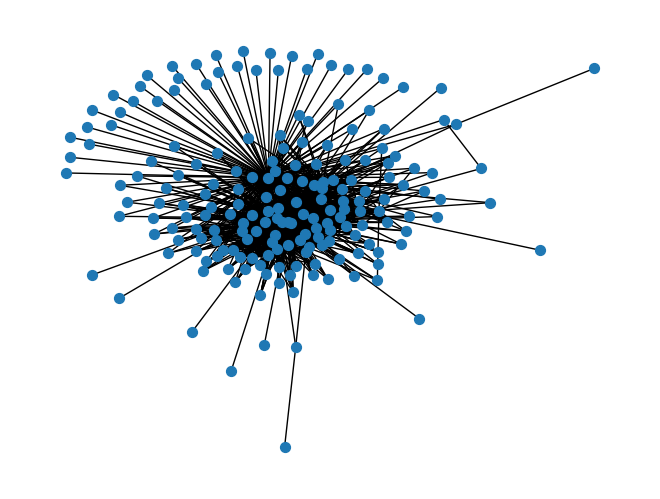

In [32]:
G = nx.Graph()
G.add_edges_from(pred_1000_edges)
nx.draw(G, node_size=50)

In [107]:
coms = algorithms.angel(G,threshold=0.99)
len(coms.communities), len(G.nodes())

(3, 193)

In [108]:
for c in coms.communities:
    print(len(c))

141
131
120


In [109]:
for c in coms.communities:
    all_mark = 0
    high_mark = 0
    for case in case_data:
        cpc = set(case['CPC']) - (set(case['CPC']) - cpc_set)
        recall = len(cpc.intersection(c))/len(cpc) if len(cpc) else 0
        if recall >= 1 and len(cpc)>1:
            all_mark += 1
        if recall>= 0.8:
            high_mark += 1
    print(len(c), all_mark, high_mark)

141 71 130
131 96 149
120 104 154


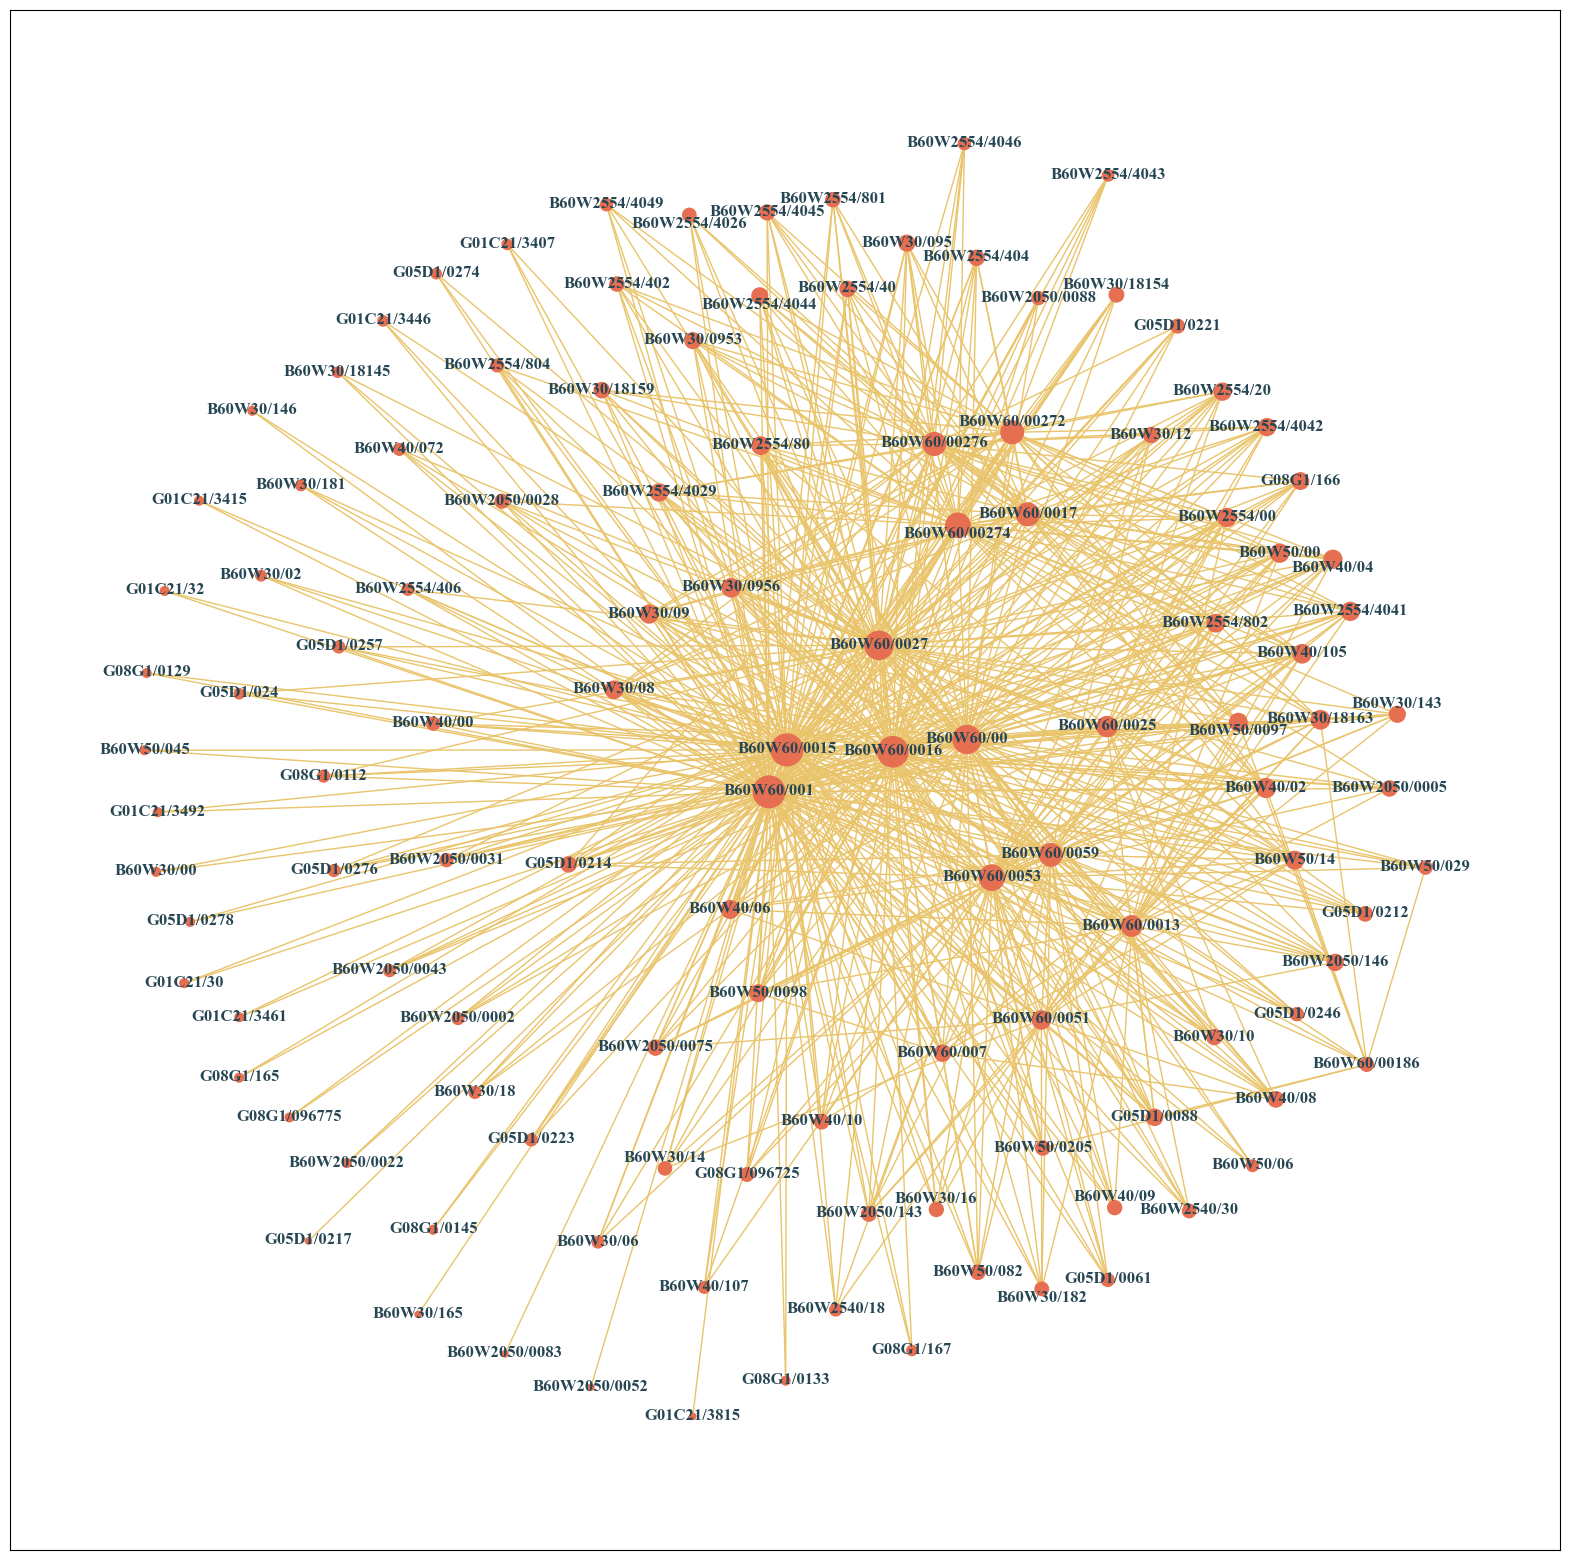

In [195]:
target_com = coms.communities[2]
sub_graph = G.subgraph(target_com)
eigenvector_cent = nx.eigenvector_centrality(sub_graph)
eigenvector_cent = list(eigenvector_cent.values())
max_eigenvector_cent = max(eigenvector_cent)
min_eigenvector_cent = min(eigenvector_cent)
eigenvector_cent = [(i-min_eigenvector_cent)/(max_eigenvector_cent-min_eigenvector_cent) for i in eigenvector_cent]

plt.figure(figsize=(20, 20))
plt.rcdefaults()
plt.rcParams['font.family'] = ['Times New Roman']

node_sizes = [i*500+20 for i in eigenvector_cent]
pos = nx.kamada_kawai_layout(sub_graph)

nx.draw_networkx_nodes(sub_graph, pos, node_size=node_sizes, node_color="#E66F51")
nx.draw_networkx_edges(sub_graph, pos, edge_color='#E9C46B', width=1)

up_nodes = ["B60W30/18154", "B60W60/00272", "B60W30/143", "B60W30/16", "B60W30/14", "B60W40/09"]  # 上移
down_nodes = ["B60W2554/4026", "B60W40/04", "B60W50/0097", "B60W30/182", "B60W60/00274", "B60W2554/4044"]   # 下移

normal_labels = {node: node for node in sub_graph.nodes() if node not in up_nodes and node not in down_nodes}
nx.draw_networkx_labels(sub_graph, pos, labels=normal_labels, font_size=12, font_color='#264653',
                        font_weight='bold', font_family='Times New Roman')

up_labels = {node: node for node in up_nodes if node in sub_graph.nodes()}
up_pos = {node: (pos[node][0], pos[node][1] + 0.015) for node in up_labels}
nx.draw_networkx_labels(sub_graph, up_pos, labels=up_labels, font_size=12, font_color='#264653',
                        font_weight='bold', font_family='Times New Roman')

down_labels = {node: node for node in down_nodes if node in sub_graph.nodes()}
down_pos = {node: (pos[node][0], pos[node][1] - 0.015) for node in down_labels}
nx.draw_networkx_labels(sub_graph, down_pos, labels=down_labels, font_size=12, font_color='#264653',
                        font_weight='bold', font_family='Times New Roman')

plt.savefig('sub_graph.png', dpi=500, bbox_inches='tight')

In [197]:
eigenvector_cent = nx.eigenvector_centrality(sub_graph)
eigenvector_cent

{'B60W60/0027': 0.2440874607491525,
 'B60W2554/4045': 0.06711509540841197,
 'B60W60/0016': 0.28388533170353797,
 'B60W2540/18': 0.04468009587748759,
 'B60W60/00': 0.24042401043168884,
 'B60W50/06': 0.04111677040115065,
 'B60W60/00186': 0.05580510300765669,
 'B60W60/0015': 0.30916256630919486,
 'B60W30/146': 0.023037847064515556,
 'B60W60/001': 0.3082461897552613,
 'B60W60/00272': 0.1565003805859305,
 'B60W60/00274': 0.18054851521238804,
 'B60W2554/404': 0.07019089594155686,
 'G01C21/3415': 0.023037847064515556,
 'B60W60/00276': 0.1579933821249949,
 'B60W60/0017': 0.15824806380870907,
 'G05D1/0246': 0.051709589816002245,
 'B60W30/143': 0.07625654452807884,
 'G01C21/32': 0.023037847064515556,
 'B60W60/0053': 0.19446060438739032,
 'B60W60/0013': 0.12818928364122245,
 'B60W30/0956': 0.10144477540521045,
 'B60W60/0059': 0.15465634406684708,
 'B60W2050/0088': 0.051709589816002245,
 'G08G1/166': 0.08327345597581519,
 'G05D1/0217': 0.011501826822067351,
 'B60W50/029': 0.05194009590000772,
 'G0

In [217]:
target_nodes = "B60W60/00186"
neighbors = list(sub_graph.neighbors(target_nodes))
neighbors = [target_nodes] + neighbors

for case in case_data:
    cpc = set(case['CPC']) - (set(case['CPC']) - cpc_set)
    recall = len(cpc.intersection(neighbors))/len(cpc) if len(cpc) else 0
    if recall >= 0.5 and len(cpc)>2 and target_nodes in cpc:
        print(case['PN'], len(case['CPC']), cpc, len(cpc.intersection(neighbors)), len(neighbors), cpc.intersection(neighbors))

US20240051554A1 8 {'B60W60/0015', 'B60W50/0205', 'B60W50/029', 'B60W60/00186', 'B60W50/023', 'B60W2050/021', 'B60W2050/0292', 'B60W2420/403'} 4 11 {'B60W50/029', 'B60W60/0015', 'B60W50/0205', 'B60W60/00186'}
US20240051578A1 5 {'B60W50/023', 'B60W50/029', 'B60W50/0205', 'B60W60/00186', 'B60W2050/0292'} 3 11 {'B60W50/029', 'B60W50/0205', 'B60W60/00186'}


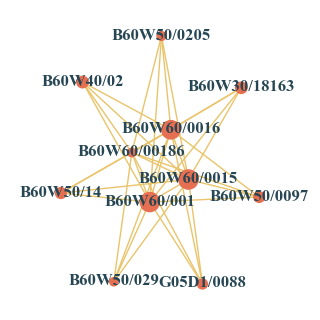

In [218]:
nodes = "B60W60/00186"
plt.figure(figsize=(3, 3))
neighbors = list(sub_graph.neighbors(nodes))
neighbors = [nodes] + neighbors
_sub_graph = sub_graph.subgraph(neighbors)
node_s = [eigenvector_cent[n] for n in _sub_graph.nodes()]
node_s = [(i-min_eigenvector_cent)/(max_eigenvector_cent-min_eigenvector_cent) for i in node_s]
node_s = [i*180+10 for i in node_s]
pos = nx.kamada_kawai_layout(_sub_graph)
nx.draw(_sub_graph, pos, with_labels=True, node_size=node_s, node_color="#E66F51", font_size=12, font_color='#264653', font_weight='bold', edge_color='#E9C46B', width=1, font_family='Times New Roman')
plt.xlim(min([pos[n][0] for n in pos.keys()])-0.5, max([pos[n][0] for n in pos.keys()])+0.5)
plt.savefig('B60W6000186.png', dpi=500, bbox_inches='tight')

In [222]:
target_nodes = "G08G1/166"
neighbors = list(sub_graph.neighbors(target_nodes))
neighbors = [target_nodes] + neighbors

for case in case_data:
    cpc = set(case['CPC']) - (set(case['CPC']) - cpc_set)
    recall = len(cpc.intersection(neighbors))/len(cpc) if len(cpc) else 0
    if recall >= 0.5 and len(cpc)>2 and target_nodes in cpc:
        print(case['PN'], len(case['CPC']), cpc, len(cpc.intersection(neighbors)), len(neighbors), cpc.intersection(neighbors))

CN116654020A 4 {'B60W60/0016', 'B60W60/00274', 'G08G1/166', 'B60W2756/10'} 3 11 {'B60W60/0016', 'G08G1/166', 'B60W60/00274'}


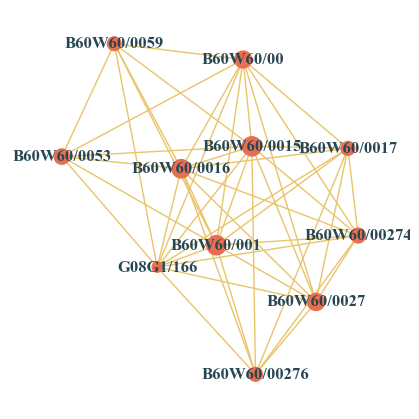

In [232]:
nodes = "G08G1/166"
plt.figure(figsize=(4, 4))
neighbors = list(sub_graph.neighbors(nodes))
neighbors = [nodes] + neighbors
_sub_graph = sub_graph.subgraph(neighbors)
node_s = [eigenvector_cent[n] for n in _sub_graph.nodes()]
node_s = [(i-min_eigenvector_cent)/(max_eigenvector_cent-min_eigenvector_cent) for i in node_s]
node_s = [i*180+10 for i in node_s]
pos = nx.kamada_kawai_layout(_sub_graph, scale=1.6)
nx.draw(_sub_graph, pos, with_labels=True, node_size=node_s, node_color="#E66F51", font_size=12, font_color='#264653', font_weight='bold', edge_color='#E9C46B', width=1, font_family='Times New Roman')
plt.xlim(min([pos[n][0] for n in pos.keys()])-0.5, max([pos[n][0] for n in pos.keys()])+0.5)
plt.savefig('G08G1166.png', dpi=500, bbox_inches='tight')

In [234]:
target_nodes = "B60W2050/0028"
neighbors = list(sub_graph.neighbors(target_nodes))
neighbors = [target_nodes] + neighbors

for case in case_data:
    cpc = set(case['CPC']) - (set(case['CPC']) - cpc_set)
    recall = len(cpc.intersection(neighbors))/len(cpc) if len(cpc) else 0
    if recall >= 0.5 and len(cpc)>2 and target_nodes in cpc:
        print(case['PN'], len(case['CPC']), cpc, len(cpc.intersection(neighbors)), len(neighbors), cpc.intersection(neighbors))

CN116872954A 3 {'B60W2050/0028', 'B60W50/08', 'B60W60/00'} 2 7 {'B60W2050/0028', 'B60W60/00'}
CN116853295A 5 {'B60W2050/0028', 'B60W50/00', 'B60W60/0027', 'B60W60/0016', 'B60W50/0097'} 3 7 {'B60W60/0027', 'B60W60/0016', 'B60W2050/0028'}
CN116861230A 6 {'B60W50/14', 'B60W2050/0062', 'B60W2050/0028', 'B60W60/00', 'B60W50/00', 'B60W60/001'} 3 7 {'B60W2050/0028', 'B60W60/00', 'B60W60/001'}


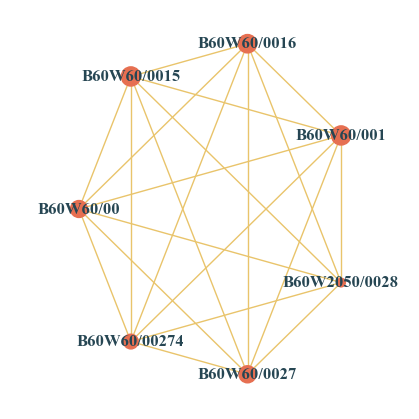

In [221]:
nodes = "B60W2050/0028"
plt.figure(figsize=(4, 4))
neighbors = list(sub_graph.neighbors(nodes))
neighbors = [nodes] + neighbors
_sub_graph = sub_graph.subgraph(neighbors)
node_s = [eigenvector_cent[n] for n in _sub_graph.nodes()]
node_s = [(i-min_eigenvector_cent)/(max_eigenvector_cent-min_eigenvector_cent) for i in node_s]
node_s = [i*180+10 for i in node_s]
pos = nx.kamada_kawai_layout(_sub_graph, scale=1)

x_center = (min(pos[n][0] for n in pos) + max(pos[n][0] for n in pos)) / 2  # 计算 x 轴中心
for node in pos:
    pos[node] = (-pos[node][0] + 2 * x_center, pos[node][1])  # 镜像公式：x' = -x + 2 * center

nx.draw(_sub_graph, pos, with_labels=True, node_size=node_s, node_color="#E66F51",
        font_size=12, font_color='#264653', font_weight='bold', edge_color='#E9C46B',
        width=1, font_family='Times New Roman')

plt.xlim(min([pos[n][0] for n in pos.keys()]) - 0.5, max([pos[n][0] for n in pos.keys()]) + 0.5)

plt.savefig('B60W20500028.png', dpi=500, bbox_inches='tight')